# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


### include all datasets

let's redo the above for all the datasets

In [2]:
warnings.filterwarnings("ignore")
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))

single_FileList1 = []
for I, _ in enumerate(full_list_MCx):
    single_FileList1.append(I)



warnings.filterwarnings("ignore")
side1df = [allDFs_MCx[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)

warnings.filterwarnings("default")

In [4]:
n_iter = 1000
n_shared_trial1 = AllData1.shape[2]
trialList1 = np.arange(n_shared_trial1)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_MCx = np.percentile(CCs1, 99, axis=1).T


if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variable: `CC_upper_bound_MCx` holds the upper bound correlations')
    del allDFs_MCx, side1df

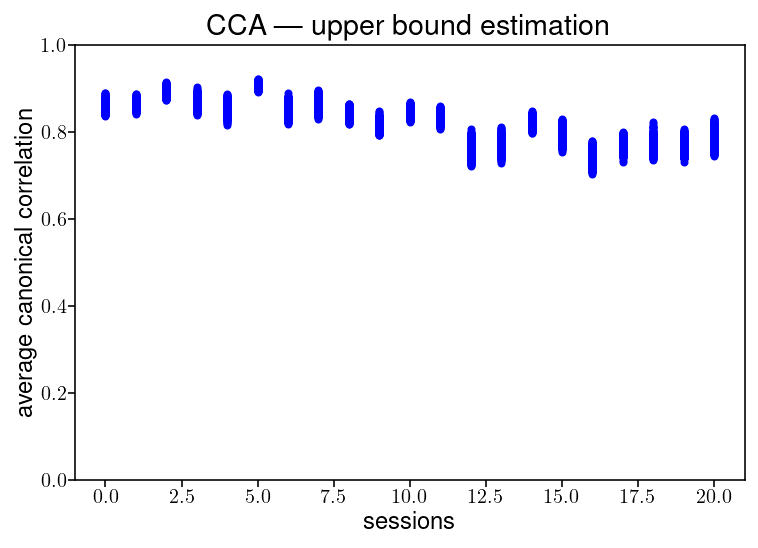

In [5]:
if "__file__" not in dir():
    M1_Lines = plt.plot(np.mean(CCs1[...,:4],axis=-1),'b.', label='MCx')
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('average canonical correlation')
    plt.title('CCA --- upper bound estimation', usetex=True);

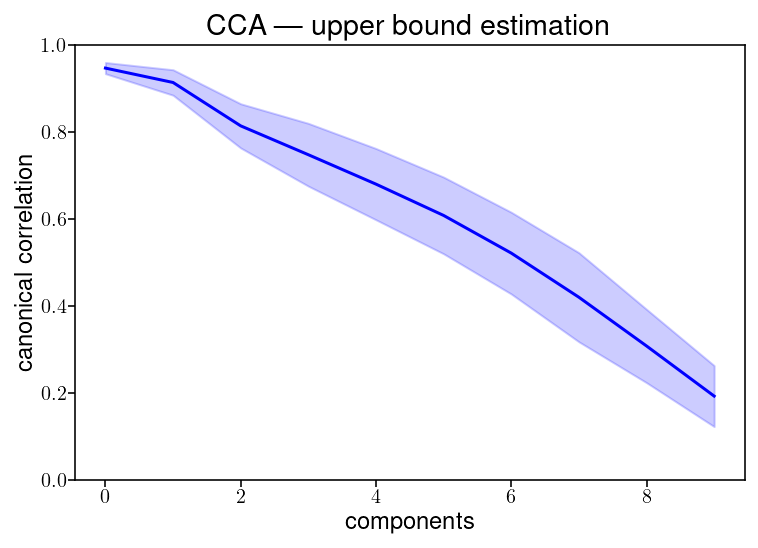

In [6]:
if "__file__" not in dir():
    _,ax = plt.subplots()
    M1_Lines,_ = utility.shaded_errorbar(ax, CC_upper_bound_MCx, color='b', label='MCx')

    plt.ylim([0,1])
    plt.xlabel('components')
    plt.ylabel('canonical correlation')
    plt.title('CCA --- upper bound estimation', usetex=True);